# REGO3 - Prédiction Émissions CO2 Bâtiments Seattle
## Notebook 02 : Préparation des Données (Train/Test)

---

### Identité
* **Population cible** : Bâtiments non-résidentiels
* **Date création** : 27 Janvier 2026
* **Objectif** : Préparer les données pour modélisation sans data leakage

### Principe fondamental
**SÉPARATION TRAIN/TEST AVANT TOUT TRAITEMENT**

Les règles de nettoyage (moyennes, limites, modes) sont apprises UNIQUEMENT sur le train set, puis appliquées au test set.

### Workflow
1. Charger les données brutes
2. Traiter la variable cible (avant split)
3. SPLIT TRAIN/TEST (seed fixe = 42)
4. Appliquer les pipelines de traitement (via src/preprocessing.py)
5. Sauvegarder outputs + paramètres

### Outputs
* `train_processed.csv` : Données train nettoyées et encodées
* `test_processed.csv` : Données test nettoyées et encodées
* `pipeline_params.pkl` : Tous les paramètres du pipeline
* `processing_report.json` : Rapport détaillé

---

## Table des matières

0. [Imports et Configuration](#section-0)
1. [Chargement des Données](#section-1)
2. [Traitement Variable Cible](#section-2)
3. [Séparation Train/Test](#section-3)
4. [Catégorisation Variables](#section-4)
5. [Pipeline Valeurs Manquantes](#section-5)
6. [Pipeline Valeurs Extrêmes](#section-6)
7. [Pipeline Features Binaires](#section-7)
8. [Pipeline Encodage Catégorielles](#section-8)
9. [Assemblage et Vérifications](#section-9)
10. [Sauvegarde Outputs](#section-10)

## Section 0 : Imports et Configuration
<a id='section-0'></a>

In [53]:
# Imports standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats as sp_stats
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
import joblib
import json
import warnings
import sys

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# Ajouter le dossier parent au path pour importer src
notebook_path = Path.cwd()
project_root = notebook_path.parent
sys.path.append(str(project_root))

# Import du module preprocessing
from src.preprocessing import (
    fit_missing_values_pipeline,
    transform_missing_values_pipeline,
    fit_outliers_pipeline,
    transform_outliers_pipeline,
    fit_binary_features_pipeline,
    transform_binary_features_pipeline,
    fit_categorical_encoder,
    transform_categorical_encoder,
    print_pipeline_summary
)

print(f"Module src.preprocessing chargé depuis : {project_root / 'src'}")

Module src.preprocessing chargé depuis : c:\Users\ndeye\OneDrive\Bureau\AS3 - Graduate\1_Projets_SEM1\Machine Learning\CO2-Emission-in-Seattle-REGO3\src


In [54]:
# Chemins
raw = Path('../data/raw_data')
interim = Path('../data/interim_data')
processed = Path('../data/processed_data')
figures = Path('../reports/figures')

# Créer dossiers si nécessaire
for path in [raw, interim, processed, figures]:
    path.mkdir(parents=True, exist_ok=True)

# Paramètres globaux
RANDOM_STATE = 42  
TEST_SIZE = 0.2    


print(f"Random state : {RANDOM_STATE}")
print(f"Test size : {TEST_SIZE * 100}%")

Random state : 42
Test size : 20.0%


## Section 1 : Chargement des Données
<a id='section-1'></a>



In [55]:
# Chargement
df = pd.read_csv(raw / 'base_raw.csv')
print(f"Dataset  : {df.shape[0]} lignes, {df.shape[1]} colonnes")

print(df['BuildingType'].value_counts())

Dataset  : 3376 lignes, 46 colonnes
BuildingType
NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: count, dtype: int64


In [56]:
df[df['BuildingType']== "Nonresidential WA"]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
3359,50101,2016,Nonresidential WA,University,Burke Museum,4331 Memorial Way NE,Seattle,WA,98195.0,1625049001,4,NORTHEAST,47.66127,-122.31256,1962,1.0,1,68072,0,68072,College/University,College/University,68916.0,NaN,NaN,NaN,NaN,NaN,NaN,46.200001,46.200001,144.899994,144.899994,3180819.25,3180819.25,0.0,932244.6875,3180819.0,0.0,0.0,False,NaN,Compliant,NaN,22.17,0.33


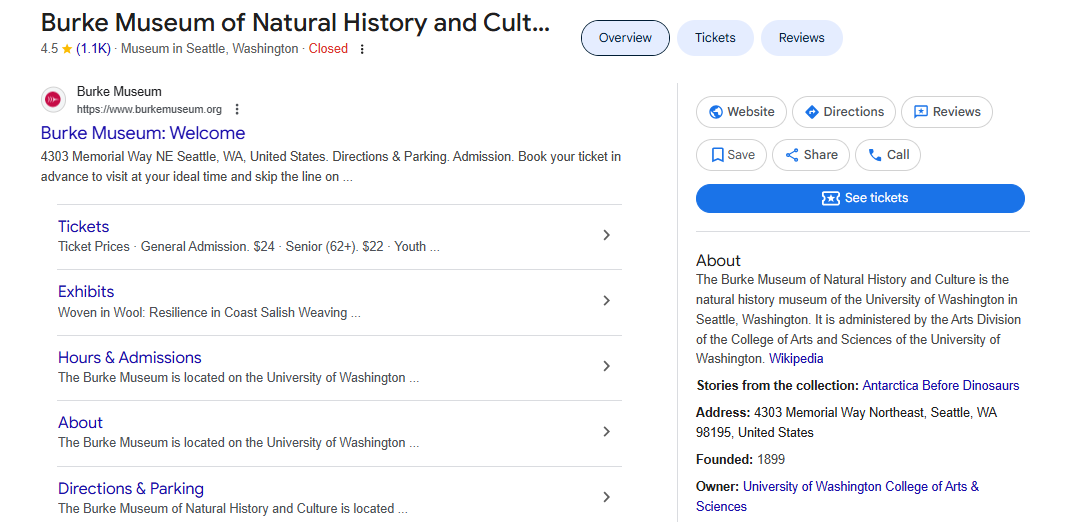

On voit clairement qu'il s'agit d'une seule observation qui coincide avec un musée, qui peut être rejoint à la catégorie des "Non residential", et en vrai, le WA peut être liée juste à l'emplacement

In [57]:
# Filtrage non-résidentiel
non_residencial = [
    'NonResidential',
    'SPS-District K-12',
    'Nonresidential COS',
    'Campus',
    'Nonresidential WA',
]

# Harmoniser libellés
df['BuildingType'] = df['BuildingType'].replace({'Nonresidential WA': 'NonResidential'})

# Filtrer 
df = df[df['BuildingType'].isin(non_residencial)].copy()
df.reset_index(drop=True, inplace=True)

print(f"Dataset initial : {df.shape[0]} lignes, {df.shape[1]} colonnes")
print(df['BuildingType'].value_counts())

Dataset initial : 1668 lignes, 46 colonnes
BuildingType
NonResidential        1461
SPS-District K-12       98
Nonresidential COS      85
Campus                  24
Name: count, dtype: int64


In [58]:
df.head(3)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.0,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.0,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.0,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19


## Section 2 : Traitement Variable Cible
<a id='section-2'></a>

### Stratégie de traitement pour TotalGHGEmissions:

La variable cible présente une distribution asymétrique positive. Nous allons:
1. Analyser la distribution originale
2. Appliquer une transformation logarithmique pour normaliser
3. Vérifier la normalité de la distribution transformée
4. Décider du traitement des valeurs extrêmes basé sur la distribution log

**Justification de la transformation log:**
- Normalise les distributions asymétriques positives
- Stabilise la variance
- Améliore les performances des modèles de régression
- Les valeurs extrêmes dans l'échelle originale deviennent normales dans l'échelle log

In [59]:
variable_cible = 'TotalGHGEmissions'
# Statistiques avant traitement
print("STATISTIQUES AVANT TRAITEMENT")
print(f"Nombre d'observations : {len(df)}")
print(f"Valeurs manquantes : {df[variable_cible].isnull().sum()}")
print(f"Valeurs négatives : {(df[variable_cible] < 0).sum()}")
print(f"\nStatistiques descriptives :")
print(df[variable_cible].describe())


STATISTIQUES AVANT TRAITEMENT
Nombre d'observations : 1668
Valeurs manquantes : 2
Valeurs négatives : 1

Statistiques descriptives :
count     1666.000000
mean       184.973301
std        751.976001
min         -0.800000
25%         19.967500
50%         49.580000
75%        142.382500
max      16870.980000
Name: TotalGHGEmissions, dtype: float64


In [60]:
# Mesures de forme
skewness = skew(df[variable_cible].dropna())
kurt = kurtosis(df[variable_cible].dropna())
print(f"Mesures de forme :")
print(f"Skewness (asymétrie) : {skewness:.3f}")
print(f"  → Valeur > 0 : distribution asymétrique à droite (positivement asymétrique)")
print(f"Kurtosis (aplatissement) : {kurt:.3f}")
print(f"  → Valeur > 0 : distribution avec queues lourdes (leptokurtique)")


Mesures de forme :
Skewness (asymétrie) : 14.201
  → Valeur > 0 : distribution asymétrique à droite (positivement asymétrique)
Kurtosis (aplatissement) : 246.357
  → Valeur > 0 : distribution avec queues lourdes (leptokurtique)


In [61]:
# Rapport Moyenne/Médiane
mean_val = df[variable_cible].mean()
median_val = df[variable_cible].median()
ratio = mean_val / median_val
print(f"Rapport Moyenne/Médiane : {ratio:.3f}")
print(f"  → Ratio > 1 confirme l'asymétrie positive")

Rapport Moyenne/Médiane : 3.731
  → Ratio > 1 confirme l'asymétrie positive


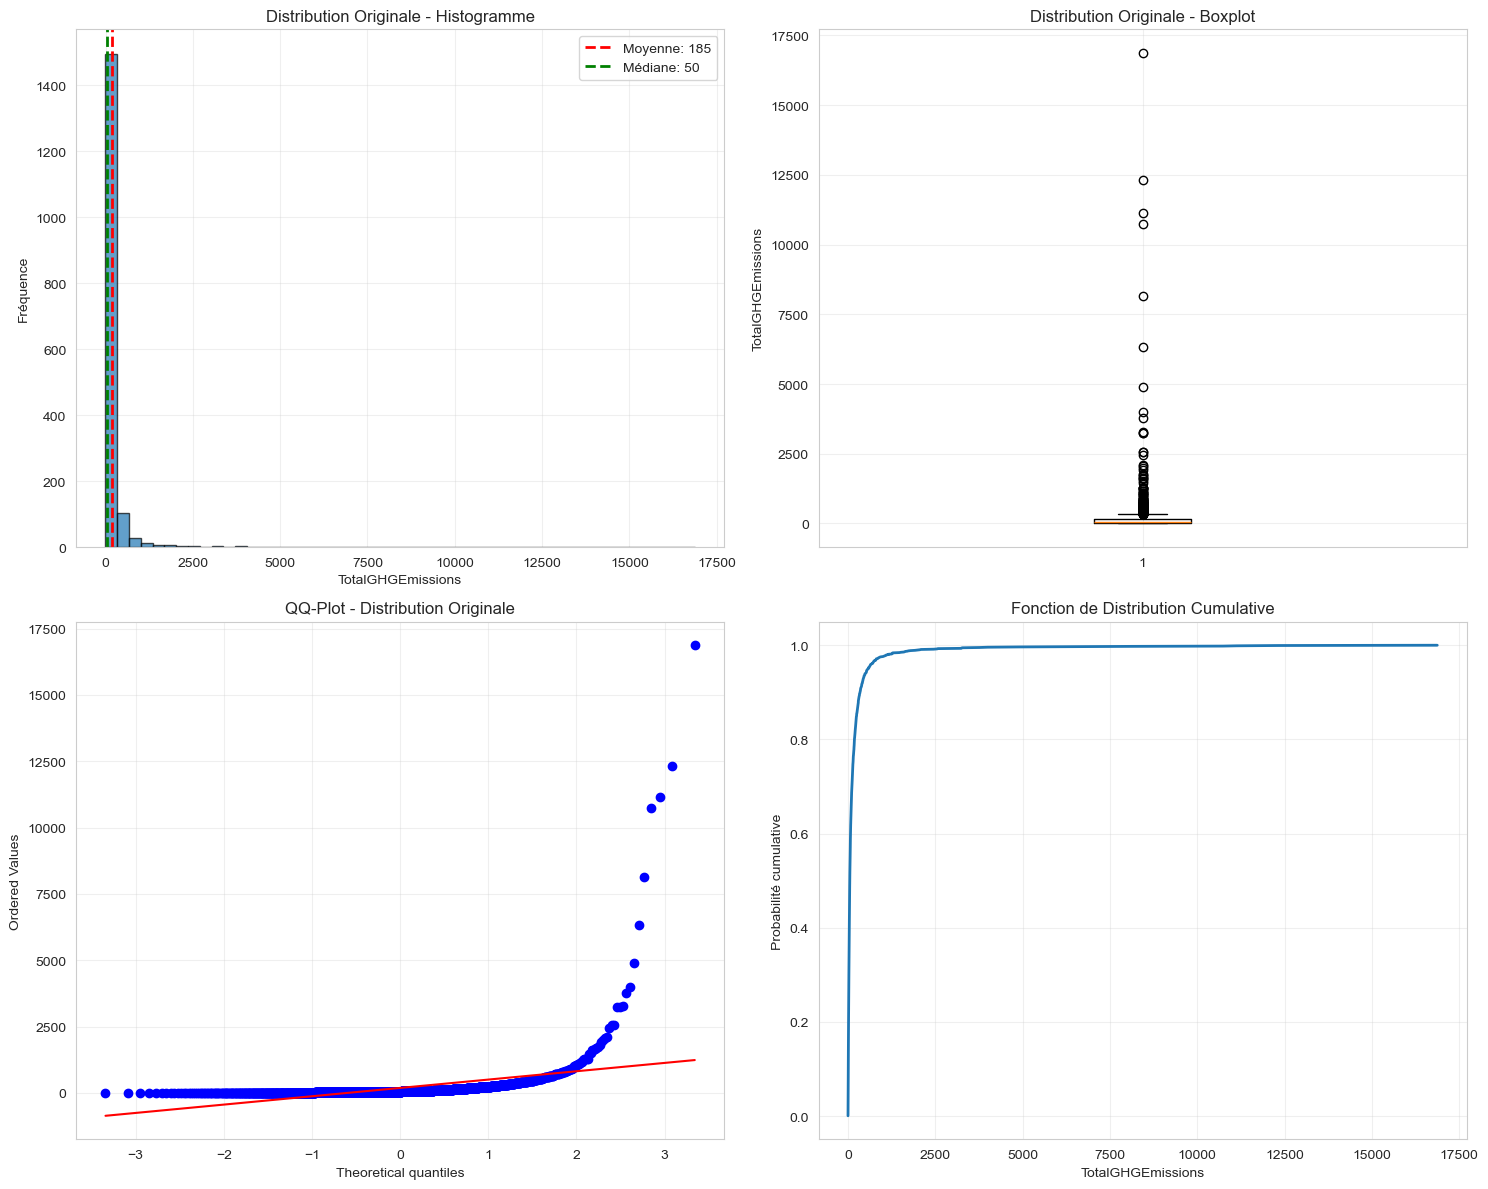


Graphiques sauvegardés : 01_target_original_distribution.png


In [62]:
# Visualisation de la distribution originale
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Histogramme
axes[0, 0].hist(df[variable_cible].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df[variable_cible].mean(), color='red', linestyle='--', 
                    linewidth=2, label=f'Moyenne: {df[variable_cible].mean():.0f}')
axes[0, 0].axvline(df[variable_cible].median(), color='green', linestyle='--', 
                    linewidth=2, label=f'Médiane: {df[variable_cible].median():.0f}')
axes[0, 0].set_xlabel('TotalGHGEmissions')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].set_title('Distribution Originale - Histogramme')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Boxplot
axes[0, 1].boxplot(df[variable_cible].dropna(), vert=True)
axes[0, 1].set_ylabel('TotalGHGEmissions')
axes[0, 1].set_title('Distribution Originale - Boxplot')
axes[0, 1].grid(True, alpha=0.3)

# QQ-plot (normalité)
sp_stats.probplot(df[variable_cible].dropna(), dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('QQ-Plot - Distribution Originale')
axes[1, 0].grid(True, alpha=0.3)

# Distribution cumulative
sorted_data = np.sort(df[variable_cible].dropna())
cumulative = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[1, 1].plot(sorted_data, cumulative, linewidth=2)
axes[1, 1].set_xlabel('TotalGHGEmissions')
axes[1, 1].set_ylabel('Probabilité cumulative')
axes[1, 1].set_title('Fonction de Distribution Cumulative')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(figures / '01_target_original_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGraphiques sauvegardés : 01_target_original_distribution.png")

Les graphiques montrent que la variable cible est effectivemnt asymétrique positivement et montre surtout la présence de valeurs extrêmes positives

### 2.1 : Suppression des valeurs manquantes

In [63]:
n_before = len(df)
df = df.dropna(subset=[variable_cible]).copy()
n_after = len(df)
n_removed = n_before - n_after


print(f"Observations supprimées : {n_removed}")
print(f"Observations restantes : {n_after}")

df.reset_index(drop=True, inplace=True)

Observations supprimées : 2
Observations restantes : 1666


### 2.2 Transformation des valeurs négatives en zéro

In [64]:
# Transformation des valeurs négatives en zéro
n_negative = (df[variable_cible] < 0).sum()
df.loc[df[variable_cible] < 0, variable_cible] = 0

print(f"Nombre de valeurs négatives corrigées : {n_negative}")
print(f"Minimum actuel : {df[variable_cible].min()}")

Nombre de valeurs négatives corrigées : 1
Minimum actuel : 0.0


### 2.3 Transformation logarithmique

In [65]:
# Utilisation de log1p pour gérer les zéros : log1p(x) = log(1 + x)
# Cela évite log(0) = -inf
df['TotalGHGEmissions_log'] = np.log1p(df[variable_cible])

print(f"Variable créée : TotalGHGEmissions_log = log(1 + TotalGHGEmissions)")
print(f"Statistiques descriptives (échelle log) :")
print(df['TotalGHGEmissions_log'].describe())


Variable créée : TotalGHGEmissions_log = log(1 + TotalGHGEmissions)
Statistiques descriptives (échelle log) :
count    1666.000000
mean        3.984839
std         1.469339
min         0.000000
25%         3.042969
50%         3.923556
75%         4.965516
max         9.733410
Name: TotalGHGEmissions_log, dtype: float64


In [66]:
# Mesures de forme après transformation
skewness_log = skew(df['TotalGHGEmissions_log'])
kurt_log = kurtosis(df['TotalGHGEmissions_log'])
print(f"\nMesures de forme (échelle log) :")
print(f"Skewness : {skewness_log:.3f} (vs {skewness:.3f} avant)")
print(f"  → Amélioration : {abs(skewness_log) < abs(skewness)}")
print(f"Kurtosis : {kurt_log:.3f} (vs {kurt:.3f} avant)")
print(f"  → Amélioration : {abs(kurt_log) < abs(kurt)}")



Mesures de forme (échelle log) :
Skewness : 0.135 (vs 14.201 avant)
  → Amélioration : True
Kurtosis : 0.322 (vs 246.357 avant)
  → Amélioration : True


In [67]:
# Rapport Moyenne/Médiane après transformation
mean_log = df['TotalGHGEmissions_log'].mean()
median_log = df['TotalGHGEmissions_log'].median()
ratio_log = mean_log / median_log
print(f"\nRapport Moyenne/Médiane (log) : {ratio_log:.3f}")
print(f"  → Plus proche de 1 = distribution plus symétrique")


Rapport Moyenne/Médiane (log) : 1.016
  → Plus proche de 1 = distribution plus symétrique


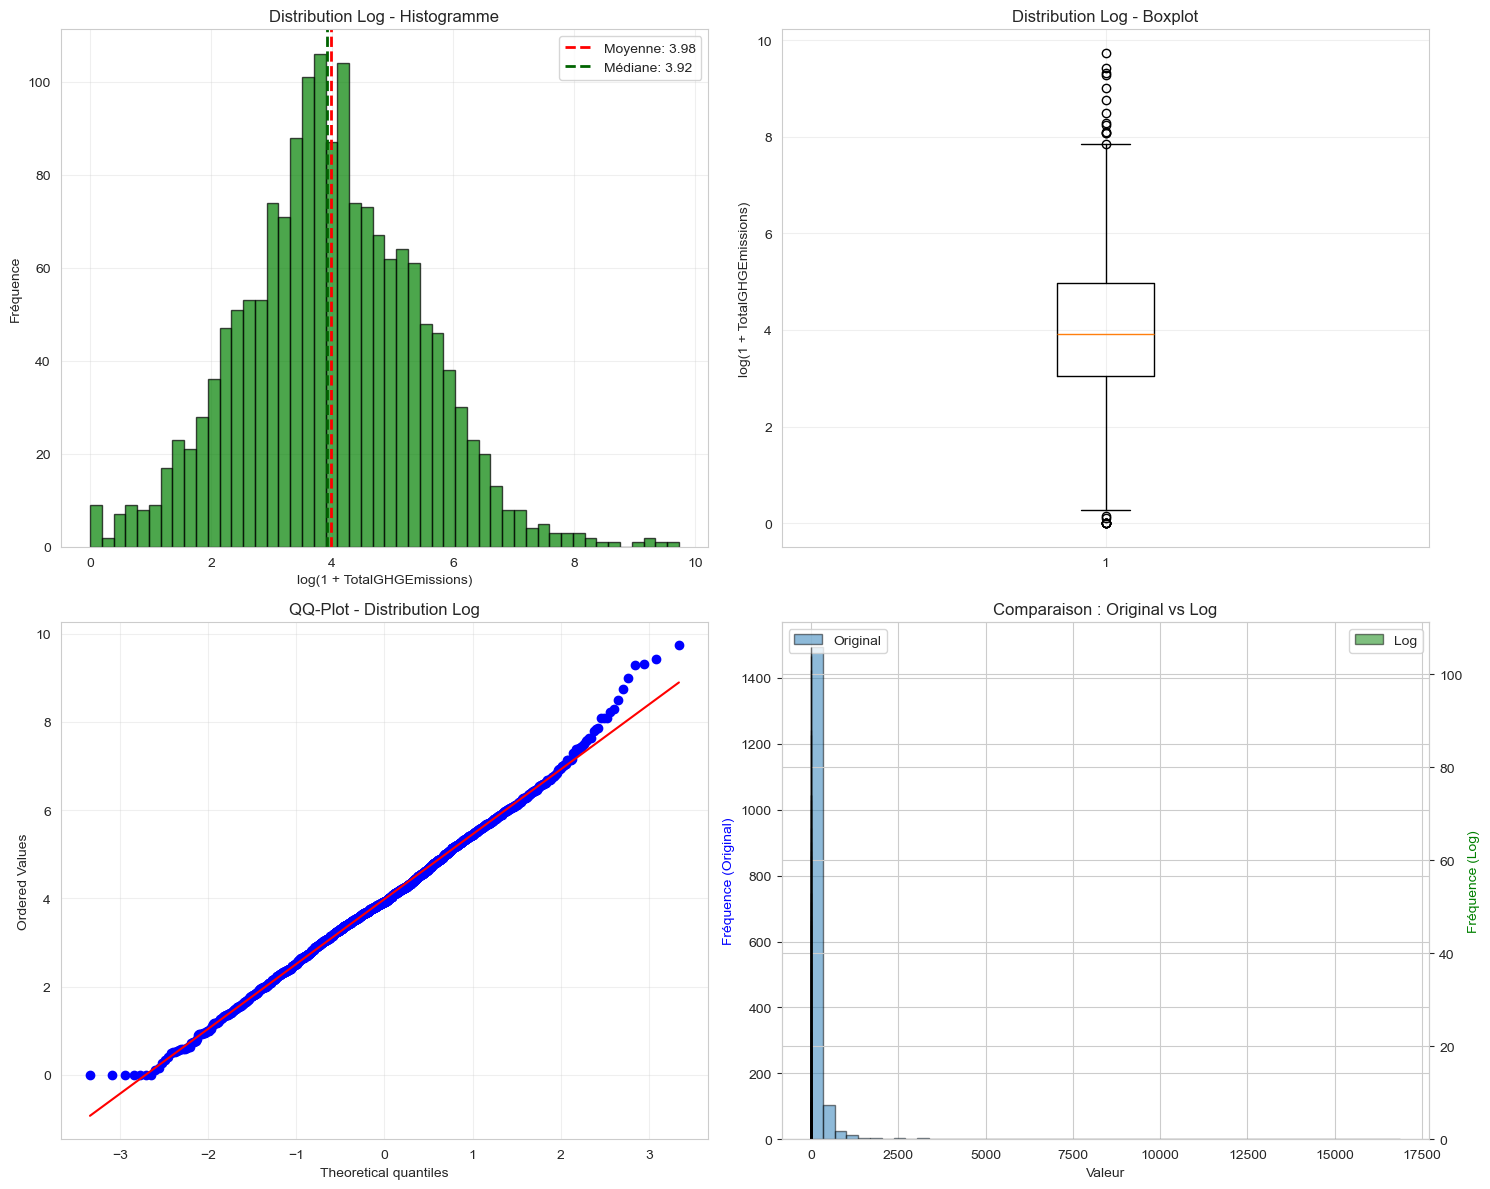


Graphiques sauvegardés : 02_target_log_distribution.png


In [68]:
# Visualisation de la distribution après transformation log
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Histogramme
axes[0, 0].hist(df['TotalGHGEmissions_log'], bins=50, edgecolor='black', 
                color='green', alpha=0.7)
axes[0, 0].axvline(df['TotalGHGEmissions_log'].mean(), color='red', 
                    linestyle='--', linewidth=2, 
                    label=f'Moyenne: {df["TotalGHGEmissions_log"].mean():.2f}')
axes[0, 0].axvline(df['TotalGHGEmissions_log'].median(), color='darkgreen', 
                    linestyle='--', linewidth=2, 
                    label=f'Médiane: {df["TotalGHGEmissions_log"].median():.2f}')
axes[0, 0].set_xlabel('log(1 + TotalGHGEmissions)')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].set_title('Distribution Log - Histogramme')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Boxplot
axes[0, 1].boxplot(df['TotalGHGEmissions_log'], vert=True)
axes[0, 1].set_ylabel('log(1 + TotalGHGEmissions)')
axes[0, 1].set_title('Distribution Log - Boxplot')
axes[0, 1].grid(True, alpha=0.3)

# QQ-plot (normalité)
sp_stats.probplot(df['TotalGHGEmissions_log'], dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('QQ-Plot - Distribution Log')
axes[1, 0].grid(True, alpha=0.3)

# Comparaison avant/après
axes[1, 1].hist(df[variable_cible], bins=50, alpha=0.5, label='Original', 
                edgecolor='black')
# Échelle secondaire pour la distribution log
ax2 = axes[1, 1].twinx()
ax2.hist(df['TotalGHGEmissions_log'], bins=50, alpha=0.5, color='green', 
         label='Log', edgecolor='black')
axes[1, 1].set_xlabel('Valeur')
axes[1, 1].set_ylabel('Fréquence (Original)', color='blue')
ax2.set_ylabel('Fréquence (Log)', color='green')
axes[1, 1].set_title('Comparaison : Original vs Log')
axes[1, 1].legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig(figures / '02_target_log_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGraphiques sauvegardés : 02_target_log_distribution.png")

Là, on voit la nette différence entre les deux. La distribution de notre variable cible est plus symétrique et semble normale

### 2.4 Test de normalité

In [69]:
# Test de Shapiro-Wilk (échantillon < 5000)
# Note : pour grands échantillons, on utilise souvent un échantillon aléatoire
sample_size = min(5000, len(df))
sample_original = df[variable_cible].sample(sample_size, random_state=42)
sample_log = df['TotalGHGEmissions_log'].sample(sample_size, random_state=42)

stat_original, p_original = sp_stats.shapiro(sample_original)
stat_log, p_log = sp_stats.shapiro(sample_log)

print(f"\nTest de Shapiro-Wilk (échantillon de {sample_size} observations) :")
print(f"\nDistribution ORIGINALE :")
print(f"  Statistique : {stat_original:.6f}")
print(f"  p-value : {p_original:.6f}")
print(f"  Conclusion : {'Distribution NORMALE' if p_original > 0.05 else 'Distribution NON-NORMALE'}")
print(f"  (H0: les données suivent une distribution normale, seuil α=0.05)")

print(f"\nDistribution LOG-TRANSFORMÉE :")
print(f"  Statistique : {stat_log:.6f}")
print(f"  p-value : {p_log:.6f}")
print(f"  Conclusion : {'Distribution NORMALE' if p_log > 0.05 else 'Distribution NON-NORMALE'}")
print(f"  (H0: les données suivent une distribution normale, seuil α=0.05)")

# Test de Kolmogorov-Smirnov
stat_ks_orig, p_ks_orig = sp_stats.kstest(sample_original, 'norm', 
                                           args=(sample_original.mean(), sample_original.std()))
stat_ks_log, p_ks_log = sp_stats.kstest(sample_log, 'norm', 
                                         args=(sample_log.mean(), sample_log.std()))

print(f"\nTest de Kolmogorov-Smirnov :")
print(f"\nDistribution ORIGINALE :")
print(f"  p-value : {p_ks_orig:.6f}")
print(f"  Conclusion : {'Distribution NORMALE' if p_ks_orig > 0.05 else 'Distribution NON-NORMALE'}")

print(f"\nDistribution LOG-TRANSFORMÉE :")
print(f"  p-value : {p_ks_log:.6f}")
print(f"  Conclusion : {'Distribution NORMALE' if p_ks_log > 0.05 else 'Distribution NON-NORMALE'}")


Test de Shapiro-Wilk (échantillon de 1666 observations) :

Distribution ORIGINALE :
  Statistique : 0.177035
  p-value : 0.000000
  Conclusion : Distribution NON-NORMALE
  (H0: les données suivent une distribution normale, seuil α=0.05)

Distribution LOG-TRANSFORMÉE :
  Statistique : 0.996717
  p-value : 0.001287
  Conclusion : Distribution NON-NORMALE
  (H0: les données suivent une distribution normale, seuil α=0.05)

Test de Kolmogorov-Smirnov :

Distribution ORIGINALE :
  p-value : 0.000000
  Conclusion : Distribution NON-NORMALE

Distribution LOG-TRANSFORMÉE :
  p-value : 0.287358
  Conclusion : Distribution NORMALE


### 2.5 Détection des valeurs extrêmes APRÈS transformation log

In [70]:
# Calcul des Z-scores sur la variable transformée
z_scores_log = np.abs(sp_stats.zscore(df['TotalGHGEmissions_log']))
threshold = 3

# Identification des valeurs extrêmes
outliers_mask_log = z_scores_log > threshold
n_outliers_log = outliers_mask_log.sum()

print(f"\nSeuil Z-score : ±{threshold}")
print(f"Nombre de valeurs extrêmes détectées (échelle log) : {n_outliers_log}")
print(f"Pourcentage : {(n_outliers_log / len(df)) * 100:.2f}%")

if n_outliers_log > 0:
    print(f"\nValeurs extrêmes (échelle log) :")
    extreme_df = pd.DataFrame({
        'TotalGHGEmissions': df.loc[outliers_mask_log, variable_cible].values,
        'TotalGHGEmissions_log': df.loc[outliers_mask_log, 'TotalGHGEmissions_log'].values,
        'Z-score': z_scores_log[outliers_mask_log]
    }).sort_values('Z-score', ascending=False).head(10)
    print(extreme_df.to_string(index=False))
else:
    print("\nAucune valeur extrême détectée après transformation log")
    print("La transformation logarithmique a normalisé la distribution avec succès")


Seuil Z-score : ±3
Nombre de valeurs extrêmes détectées (échelle log) : 7
Pourcentage : 0.42%

Valeurs extrêmes (échelle log) :
 TotalGHGEmissions  TotalGHGEmissions_log  Z-score
          16870.98               9.733410 3.913527
          12307.16               9.418018 3.698813
          11140.56               9.318438 3.631021
          10734.57               9.281318 3.605751
           8145.52               9.005346 3.417874
           6330.91               8.753357 3.246324
           4906.33               8.498485 3.072812


In [71]:
# Critères de décision
pct_outliers = (n_outliers_log / len(df)) * 100
is_normal = p_log > 0.05  # Basé sur le test de Shapiro-Wilk

print(f"\nCritères d'évaluation :")
print(f"1. Pourcentage d'outliers : {pct_outliers:.2f}%")
print(f"2. Distribution normale (Shapiro-Wilk) : {'Oui' if is_normal else 'Non'}")
print(f"3. Skewness proche de 0 : {abs(skewness_log) < 0.5}")
print(f"4. Rapport Moyenne/Médiane proche de 1 : {abs(ratio_log - 1) < 0.1}")

# Décision automatique
if pct_outliers < 1 and abs(skewness_log) < 0.5:
    print(f"\n{'='*80}")
    print("RECOMMANDATION : PAS DE TRAITEMENT DES OUTLIERS NÉCESSAIRE")
    print("="*80)
    print("Raisons :")
    print("- La transformation log a normalisé la distribution")
    print("- Très peu d'outliers détectés (<1%)")
    print("- La skewness est faible")
    print("- Les outliers peuvent contenir de l'information utile")
    print("\nVariable cible finale : TotalGHGEmissions_log")
    
    # Pas de traitement supplémentaire
    traitement_applique = "Aucun"
    
else:
    print(f"\n{'='*80}")
    print("RECOMMANDATION : TRAITEMENT DES OUTLIERS (CAPPING)")
    print("="*80)
    print("Raisons :")
    print(f"- Nombre significatif d'outliers : {n_outliers_log} ({pct_outliers:.2f}%)")
    print("- Application du capping à ±3 écarts-types")
    
    # Application du traitement
    mean_log = df['TotalGHGEmissions_log'].mean()
    std_log = df['TotalGHGEmissions_log'].std()
    upper_limit = mean_log + (threshold * std_log)
    lower_limit = mean_log - (threshold * std_log)
    
    df['TotalGHGEmissions_log'] = df['TotalGHGEmissions_log'].clip(
        lower=lower_limit, upper=upper_limit
    )
    
    print(f"\nLimites appliquées :")
    print(f"  Limite inférieure : {lower_limit:.3f}")
    print(f"  Limite supérieure : {upper_limit:.3f}")
    print(f"\nVariable cible finale : TotalGHGEmissions_log (avec capping)")
    
    traitement_applique = "Capping Z-score ±3"


Critères d'évaluation :
1. Pourcentage d'outliers : 0.42%
2. Distribution normale (Shapiro-Wilk) : Non
3. Skewness proche de 0 : True
4. Rapport Moyenne/Médiane proche de 1 : True

RECOMMANDATION : PAS DE TRAITEMENT DES OUTLIERS NÉCESSAIRE
Raisons :
- La transformation log a normalisé la distribution
- Très peu d'outliers détectés (<1%)
- La skewness est faible
- Les outliers peuvent contenir de l'information utile

Variable cible finale : TotalGHGEmissions_log


In [72]:
# Résumé final du traitement de la variable cible
print("\n" + "="*80)
print("RÉSUMÉ FINAL - TRAITEMENT VARIABLE CIBLE")
print("="*80)

summary_target = pd.DataFrame({
    'Étape': [
        'Dataset initial',
        'Après suppression missing',
        'Après correction négatifs',
        'Après transformation log',
        'Après traitement outliers'
    ],
    'Observations': [
        n_before,
        n_after,
        n_after,
        len(df),
        len(df)
    ],
    'Variable': [
        'TotalGHGEmissions',
        'TotalGHGEmissions',
        'TotalGHGEmissions',
        'TotalGHGEmissions_log',
        'TotalGHGEmissions_log'
    ],
    'Action': [
        '-',
        f'{n_removed} obs. supprimées',
        f'{n_negative} valeurs corrigées',
        'Transformation log(1+y)',
        traitement_applique
    ]
})

print(summary_target.to_string(index=False))

print(f"\n{'='*80}")
print("STATISTIQUES FINALES")
print("="*80)
print(f"\nVariable cible finale : TotalGHGEmissions_log")
print(df['TotalGHGEmissions_log'].describe())

print(f"\nSkewness finale : {skew(df['TotalGHGEmissions_log']):.3f}")
print(f"Kurtosis finale : {kurtosis(df['TotalGHGEmissions_log']):.3f}")
print(f"Rapport Moyenne/Médiane : {df['TotalGHGEmissions_log'].mean() / df['TotalGHGEmissions_log'].median():.3f}")

print(f"\n{'='*80}")
print("IMPORTANT POUR LA MODÉLISATION")
print("="*80)
print("Variable à utiliser : TotalGHGEmissions_log")
print("\nPour obtenir les prédictions en échelle originale :")
print("  y_pred_original = np.expm1(y_pred_log)")
print("  (expm1 est l'inverse de log1p)")
print("\nOu utiliser TransformedTargetRegressor de scikit-learn")
print("="*80)


RÉSUMÉ FINAL - TRAITEMENT VARIABLE CIBLE
                    Étape  Observations              Variable                  Action
          Dataset initial          1668     TotalGHGEmissions                       -
Après suppression missing          1666     TotalGHGEmissions       2 obs. supprimées
Après correction négatifs          1666     TotalGHGEmissions     1 valeurs corrigées
 Après transformation log          1666 TotalGHGEmissions_log Transformation log(1+y)
Après traitement outliers          1666 TotalGHGEmissions_log                   Aucun

STATISTIQUES FINALES

Variable cible finale : TotalGHGEmissions_log
count    1666.000000
mean        3.984839
std         1.469339
min         0.000000
25%         3.042969
50%         3.923556
75%         4.965516
max         9.733410
Name: TotalGHGEmissions_log, dtype: float64

Skewness finale : 0.135
Kurtosis finale : 0.322
Rapport Moyenne/Médiane : 1.016

IMPORTANT POUR LA MODÉLISATION
Variable à utiliser : TotalGHGEmissions_log

Pou

### Suppression des variables non utiles

Il y a certaines variables de consommation qui ne serviront ni dans la modélisation because they do not serve the purpose of our prediction meaning they give information that is not at all available when the prediction is scheduled (before the building is constructed, for exemple the electricity consumption is not know.) For some, on va les garder pour en faire d'autres variables.

In [73]:
variables_suppr = ['NaturalGas(kBtu)',
    'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
    'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
    'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
    'GHGEmissionsIntensity', 'Electricity(kBtu)',]

var_id_inutiles = ['TaxParcelIdentificationNumber', 'DefaultData',
                    'PropertyName','Comments', 'ComplianceStatus', 
                    'Outlier', 'ZipCode', 'CouncilDistrictCode', 'OSEBuildingID']

In [74]:
# Suppression des variables inutiles du dataset
df = df.drop(columns=variables_suppr + var_id_inutiles)


print(f"Shape après suppression : {df.shape}")
print(f"Colonnes restantes : {list(df.columns)}")

Shape après suppression : (1666, 29)
Colonnes restantes : ['DataYear', 'BuildingType', 'PrimaryPropertyType', 'Address', 'City', 'State', 'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SteamUse(kBtu)', 'Electricity(kWh)', 'NaturalGas(therms)', 'TotalGHGEmissions', 'TotalGHGEmissions_log']


## Section 3 : Séparation Train/Test
<a id='section-3'></a>

À partir de maintenant, TOUTES les statistiques seront calculées sur le train set uniquement.

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1666 entries, 0 to 1665
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   DataYear                         1666 non-null   int64  
 1   BuildingType                     1666 non-null   object 
 2   PrimaryPropertyType              1666 non-null   object 
 3   Address                          1666 non-null   object 
 4   City                             1666 non-null   object 
 5   State                            1666 non-null   object 
 6   Neighborhood                     1666 non-null   object 
 7   Latitude                         1666 non-null   float64
 8   Longitude                        1666 non-null   float64
 9   YearBuilt                        1666 non-null   int64  
 10  NumberofBuildings                1666 non-null   float64
 11  NumberofFloors                   1666 non-null   int64  
 12  PropertyGFATotal    

In [76]:
# Séparation
train_df, test_df = train_test_split(
    df,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
    
)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [77]:

print(f"Dataset total : {len(df)} observations")
print(f"Train set : {len(train_df)} observations ({len(train_df)/len(df)*100:.1f}%)")
print(f"Test set : {len(test_df)} observations ({len(test_df)/len(df)*100:.1f}%)")

# Vérification distribution cible
print(f"Distribution cible (log) :")
print(f"Train - Moyenne : {train_df['TotalGHGEmissions_log'].mean():.3f}")
print(f"Test  - Moyenne : {test_df['TotalGHGEmissions_log'].mean():.3f}")


Dataset total : 1666 observations
Train set : 1332 observations (80.0%)
Test set : 334 observations (20.0%)
Distribution cible (log) :
Train - Moyenne : 3.976
Test  - Moyenne : 4.021


In [78]:
print(df['ENERGYSTARScore'].isna().sum())
print(train_df['ENERGYSTARScore'].isna().sum())
print(test_df['ENERGYSTARScore'].isna().sum())

572
457
115


## Section 4 : Catégorisation des variables
<a id='section-4'></a>

Nous séparons les données en plusieurs groupes pour un traitement ciblé:
- **Groupe 1** : Variables autorisées + Variables ID (à traiter)
- **Groupe 2** : Variables Energy Star Score (pour le benchmarking)
- **Groupe 3** : Variables de consommation (pour feature engineering)

In [79]:
df.columns

Index(['DataYear', 'BuildingType', 'PrimaryPropertyType', 'Address', 'City',
       'State', 'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'NaturalGas(therms)', 'TotalGHGEmissions', 'TotalGHGEmissions_log'],
      dtype='object')

In [80]:
# Variables cibles
variables_cibles = ['TotalGHGEmissions', 'TotalGHGEmissions_log']


# Variables ID
variables_id = ['OSEBuildingID', 'DataYear', 
    'Address']

# Variables autorisées (disponibles au moment du permis de construction)
variables_autorisees = [
    # Identification & localisation
    'BuildingType', 'PrimaryPropertyType', 'City', 'State', 'Neighborhood', 'Latitude', 'Longitude',
    
    # Caractéristiques structurelles
    'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
    'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
    
    # Typologie d'usage
    'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
    'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
    'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
    'ThirdLargestPropertyUseTypeGFA'
]

# Variable Energy Star Score
variables_energy_star = ['ENERGYSTARScore', 'YearsENERGYSTARCertified']

# Variables de consommation (pour transformation binaire)
variables_consommation= [
    'SteamUse(kBtu)', 'Electricity(kWh)', 'NaturalGas(therms)'
]

# Mapping pour features binaires
binary_mapping = {
    'HasElectricity': 'Electricity(kWh)',
    'HasNaturalGas': 'NaturalGas(therms)',
    'HasSteam': 'SteamUse(kBtu)'
}


# Variables catégorielles (pour encodage)
variables_categorielles = [
    'PrimaryPropertyType', 'Neighborhood',
    'LargestPropertyUseType', 'SecondLargestPropertyUseType'
]



print(f"Variable cible : {variables_cibles}")
print(f"Variables ID : {len(variables_id)}")
print(f"Variables autorisées : {len(variables_autorisees)}")
print(f"Variables Energy Star : {len(variables_energy_star)}")
print(f"Variables consommation : {len(variables_consommation)}")

Variable cible : ['TotalGHGEmissions', 'TotalGHGEmissions_log']
Variables ID : 3
Variables autorisées : 20
Variables Energy Star : 2
Variables consommation : 3


In [81]:
train_df.isna().sum()

DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
Address                               0
City                                  0
State                                 0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     0
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             0
LargestPropertyUseType                3
LargestPropertyUseTypeGFA             3
SecondLargestPropertyUseType        671
SecondLargestPropertyUseTypeGFA     671
ThirdLargestPropertyUseType        1060
ThirdLargestPropertyUseTypeGFA     1060
YearsENERGYSTARCertified           1260
ENERGYSTARScore                     457
SteamUse(kBtu)                        0


In [82]:
missing_percentage = (train_df.isnull().sum() / len(train_df) * 100).sort_values(ascending=False)
missing_df = pd.DataFrame({
    'Variable': missing_percentage.index,
    'Pourcentage manquant': missing_percentage.values.round(2)
})
print(missing_df.to_string(index=False))

                       Variable  Pourcentage manquant
       YearsENERGYSTARCertified                 94.59
 ThirdLargestPropertyUseTypeGFA                 79.58
    ThirdLargestPropertyUseType                 79.58
SecondLargestPropertyUseTypeGFA                 50.38
   SecondLargestPropertyUseType                 50.38
                ENERGYSTARScore                 34.31
      LargestPropertyUseTypeGFA                  0.23
         LargestPropertyUseType                  0.23
                       DataYear                  0.00
      ListOfAllPropertyUseTypes                  0.00
              TotalGHGEmissions                  0.00
             NaturalGas(therms)                  0.00
               Electricity(kWh)                  0.00
                 SteamUse(kBtu)                  0.00
         PropertyGFABuilding(s)                  0.00
                   BuildingType                  0.00
             PropertyGFAParking                  0.00
               PropertyGFATo

<Axes: >

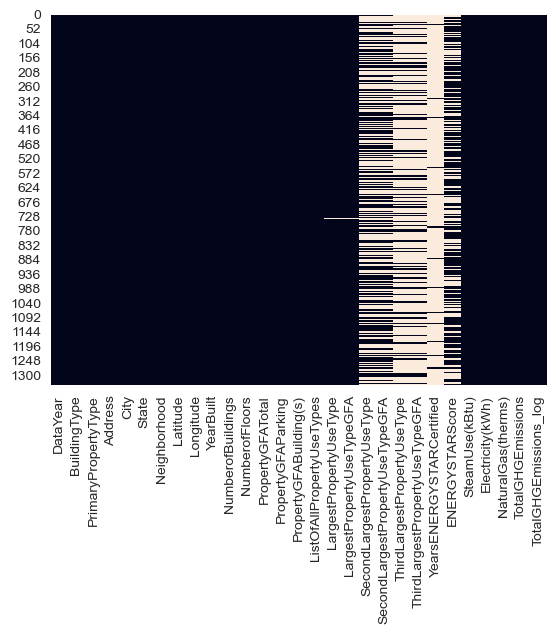

In [83]:

sns.heatmap(train_df.isnull(), cbar=False)

### Exploration de la nature des valeurs manquantes


#### Étape 1 : Catégorisation des variables selon % de valeurs manquantes

Nous appliquons la stratégie suivante :
- **> 70%** : Suppression automatique
- **10-70%** : Tests statistiques MCAR/MAR/MNAR puis imputation adaptée
- **< 10%** : Imputation simple (moyenne/mode)

In [84]:
# Calculer pourcentage de missing par variable
missing_pct = (train_df.isnull().sum() / len(train_df)) * 100

# Catégoriser selon seuils
to_drop = missing_pct[missing_pct > 70].sort_values(ascending=False)
to_test = missing_pct[(missing_pct >= 10) & (missing_pct <= 70)].sort_values(ascending=False)
to_simple = missing_pct[(missing_pct > 0) & (missing_pct < 10)].sort_values(ascending=False)



print("CATÉGORISATION DES VARIABLES SELON % MISSING")

print(f"1. SUPPRESSION (>70% missing) : {len(to_drop)} variable(s)")
if len(to_drop) > 0:
    for var, pct in to_drop.items():
        print(f"   {var:50s} : {pct:6.2f}%")

print(f"2. À TESTER (10-70% missing) : {len(to_test)} variable(s)")
if len(to_test) > 0:
    for var, pct in to_test.items():
        print(f"   {var:50s} : {pct:6.2f}%")

print(f"3. IMPUTATION SIMPLE (<10% missing) : {len(to_simple)} variable(s)")
if len(to_simple) > 0:
    for var, pct in to_simple.items():
        print(f"   {var:50s} : {pct:6.2f}%")

CATÉGORISATION DES VARIABLES SELON % MISSING
1. SUPPRESSION (>70% missing) : 3 variable(s)
   YearsENERGYSTARCertified                           :  94.59%
   ThirdLargestPropertyUseType                        :  79.58%
   ThirdLargestPropertyUseTypeGFA                     :  79.58%
2. À TESTER (10-70% missing) : 3 variable(s)
   SecondLargestPropertyUseType                       :  50.38%
   SecondLargestPropertyUseTypeGFA                    :  50.38%
   ENERGYSTARScore                                    :  34.31%
3. IMPUTATION SIMPLE (<10% missing) : 2 variable(s)
   LargestPropertyUseType                             :   0.23%
   LargestPropertyUseTypeGFA                          :   0.23%


#### Étape 2 : Test de Little (MCAR)

Pour chaque variable avec 10-70% de valeurs manquantes, nous testons :

**Hypothèses :**
- H0 : Les données sont MCAR (Missing Completely At Random)
- H1 : Les données ne sont PAS MCAR

**Interprétation :**
- p-value > 0.05 : Ne pas rejeter H0 → Données potentiellement MCAR
- p-value < 0.05 : Rejeter H0 → Données PAS MCAR (nécessite test MAR/MNAR)

In [85]:
from src.preprocessing_advanced import little_mcar_test

# Stocker résultats
little_results = {}

print("TEST DE LITTLE (MCAR)")

if len(to_test) > 0:
    for var in to_test.index:
        if var in train_df.columns:
            result = little_mcar_test(train_df[[var]])
            little_results[var] = result
            
            print(f"\n{var}:")
            print(f"  % Missing: {to_test[var]:.2f}%")
            print(f"  Statistique: {result['statistic']:.4f}")
            print(f"  P-value: {result['p_value']:.4f}")
            print(f"  Résultat: {result['conclusion']}")
else:
    print("Aucune variable dans la plage 10-70% de missing.")

TEST DE LITTLE (MCAR)

SecondLargestPropertyUseType:
  % Missing: 50.38%
  Statistique: 0.0000
  P-value: 1.0000
  Résultat: MCAR

SecondLargestPropertyUseTypeGFA:
  % Missing: 50.38%
  Statistique: 0.0000
  P-value: 1.0000
  Résultat: MCAR

ENERGYSTARScore:
  % Missing: 34.31%
  Statistique: 0.0000
  P-value: 1.0000
  Résultat: MCAR


#### Étape 4 : Tableau récapitulatif des mécanismes détectés

In [86]:
# Créer tableau récapitulatif
summary_data = []

for var in to_test.index:
    if var in little_results:
        little_res = little_results[var]
        
        # Déterminer mécanisme
        if little_res['is_mcar']:
            mechanism = 'MCAR'
            predictors = []
        else:
            mechanism = 'Non testé'
            predictors = []
        
        summary_data.append({
            'Variable': var,
            'Missing_%': round(to_test[var], 2),
            'Little_p_value': round(little_res['p_value'], 4),
            'Mécanisme': mechanism
        })

if len(summary_data) > 0:
    summary_df = pd.DataFrame(summary_data)
    
    print("TABLEAU RÉCAPITULATIF : MÉCANISMES DE MISSINGNESS DÉTECTÉS")
    print(summary_df.to_string(index=False))
    
    # Statistiques
    print("STATISTIQUES")
    print(f"Total variables testées : {len(summary_df)}")
    for mech in summary_df['Mécanisme'].unique():
        count = (summary_df['Mécanisme'] == mech).sum()
        print(f"  {mech} : {count}")
else:
    summary_df = pd.DataFrame()
    print("Aucune variable testée.")

TABLEAU RÉCAPITULATIF : MÉCANISMES DE MISSINGNESS DÉTECTÉS
                       Variable  Missing_%  Little_p_value Mécanisme
   SecondLargestPropertyUseType      50.38             1.0      MCAR
SecondLargestPropertyUseTypeGFA      50.38             1.0      MCAR
                ENERGYSTARScore      34.31             1.0      MCAR
STATISTIQUES
Total variables testées : 3
  MCAR : 3


## Section 5 : Application du Pipeline Avancé

Nous appliquons maintenant le pipeline complet qui utilise les résultats des tests pour choisir la méthode d'imputation appropriée.

In [87]:
from src.preprocessing_advanced import (
    fit_missing_values_pipeline_advanced,
    transform_missing_values_pipeline_advanced
)

print("FIT PIPELINE AVANCÉ SUR TRAIN")

# Fit avec tests activés
missing_params_advanced = fit_missing_values_pipeline_advanced(
    train_df,
    threshold_drop=0.70,
    threshold_simple=0.10,
    test_mechanism=True
)

print(f"Résultats du pipeline :")
print(f"  Colonnes à supprimer (>70%) : {len(missing_params_advanced['cols_to_drop'])}")
print(f"  Colonnes à supprimer (valeur unique) : {len(missing_params_advanced['cols_to_drop_unique'])}")
print(f"  Imputation simple (<10%) : {len(missing_params_advanced['simple_impute']['mean']) + len(missing_params_advanced['simple_impute']['mode'])}")
print(f"  Imputation avancée (10-70%) : {len(missing_params_advanced['advanced_impute'])}")

FIT PIPELINE AVANCÉ SUR TRAIN
Résultats du pipeline :
  Colonnes à supprimer (>70%) : 3
  Colonnes à supprimer (valeur unique) : 3
  Imputation simple (<10%) : 2
  Imputation avancée (10-70%) : 3


In [88]:
print(missing_params_advanced['cols_to_drop_unique'])

['DataYear', 'City', 'State']


In [89]:
print(missing_params_advanced['cols_to_drop'])

['ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified']


In [90]:
print(missing_params_advanced['advanced_impute'])

{'SecondLargestPropertyUseType': {'method': 'mode', 'value': 'Parking'}, 'SecondLargestPropertyUseTypeGFA': {'method': 'median', 'value': 11745.0}, 'ENERGYSTARScore': {'method': 'median', 'value': 73.0}}


In [91]:
# Afficher détails des imputations avancées
if len(missing_params_advanced['advanced_impute']) > 0:
    print("MÉTHODES D'IMPUTATION AVANCÉE")

    for var, impute_info in missing_params_advanced['advanced_impute'].items():
        mechanism = missing_params_advanced['mechanisms'].get(var, 'N/A')
        method = impute_info['method']
        
        print(f"{var}:")
        print(f"  Mécanisme détecté: {mechanism}")
        print(f"  Méthode imputation: {method}")
        
        if 'predictors' in impute_info and impute_info['predictors']:
            print(f"  Prédicteurs utilisés: {impute_info['predictors']}")
        elif 'value' in impute_info:
            print(f"  Valeur imputation: {impute_info['value']:.4f}" if isinstance(impute_info['value'], float) else f"  Valeur imputation: {impute_info['value']}")

MÉTHODES D'IMPUTATION AVANCÉE
SecondLargestPropertyUseType:
  Mécanisme détecté: MCAR
  Méthode imputation: mode
  Valeur imputation: Parking
SecondLargestPropertyUseTypeGFA:
  Mécanisme détecté: MCAR
  Méthode imputation: median
  Valeur imputation: 11745.0000
ENERGYSTARScore:
  Mécanisme détecté: MCAR
  Méthode imputation: median
  Valeur imputation: 73.0000


In [92]:
print("TRANSFORM : APPLICATION DU PIPELINE")

# Transform train
print("\Traitement TRAIN...")
train_clean = transform_missing_values_pipeline_advanced(train_df, missing_params_advanced)
print(f"  Shape avant : {train_df.shape}")
print(f"  Shape après : {train_clean.shape}")
print(f"  Colonnes supprimées : {train_df.shape[1] - train_clean.shape[1]}")
print(f"  Valeurs manquantes après : {train_clean.isnull().sum().sum()}")

# Transform test
print("\nTraitement TEST...")
test_clean = transform_missing_values_pipeline_advanced(test_df, missing_params_advanced)
print(f"  Shape avant : {test_df.shape}")
print(f"  Shape après : {test_clean.shape}")
print(f"  Colonnes supprimées : {test_df.shape[1] - test_clean.shape[1]}")
print(f"  Valeurs manquantes après : {test_clean.isnull().sum().sum()}")

# Vérification
print(f"\n" + "="*80)
print("VÉRIFICATION ANTI-LEAKAGE")
print("="*80)
print(f"Même nombre de colonnes : {train_clean.shape[1] == test_clean.shape[1]} ✓" if train_clean.shape[1] == test_clean.shape[1] else f"Même nombre de colonnes : {train_clean.shape[1] == test_clean.shape[1]} ✗")

TRANSFORM : APPLICATION DU PIPELINE
\Traitement TRAIN...
  Shape avant : (1332, 29)
  Shape après : (1332, 23)
  Colonnes supprimées : 6
  Valeurs manquantes après : 0

Traitement TEST...
  Shape avant : (334, 29)
  Shape après : (334, 23)
  Colonnes supprimées : 6
  Valeurs manquantes après : 0

VÉRIFICATION ANTI-LEAKAGE
Même nombre de colonnes : True ✓


## Section 6 : Traitement des Valeurs Extrêmes

### Approche multi-méthodes :
1. **Détection univariée** : IQR (Interquartile Range)
2. **Détection multivariée** : Leverage, Cook's distance, DFFITS
3. **Traitement** : Winsorisation (5e et 95e percentile)

In [93]:
from src.preprocessing_advanced import detect_outliers_univariate

print("="*80)
print("DÉTECTION UNIVARIÉE (IQR)")
print("="*80)

# Détection IQR
outliers_iqr = detect_outliers_univariate(
    train_clean,
    method='iqr',
    threshold=1.5
)

print(f"\nOutliers détectés par variable :")
print(f"{'Variable':<50s} {'N outliers':<12s} {'%':<10s}")


total_detections = 0
for col, is_outlier in outliers_iqr.items():
    n_outliers = is_outlier.sum()
    if n_outliers > 0:
        pct_outliers = (n_outliers / len(train_clean)) * 100
        print(f"{col:<50s} {n_outliers:<12d} {pct_outliers:<10.2f}")
        total_detections += n_outliers


print(f"Total détections (cumul sur toutes variables) : {total_detections}")

DÉTECTION UNIVARIÉE (IQR)

Outliers détectés par variable :
Variable                                           N outliers   %         
Longitude                                          156          11.71     
NumberofBuildings                                  90           6.76      
NumberofFloors                                     110          8.26      
PropertyGFATotal                                   160          12.01     
PropertyGFAParking                                 267          20.05     
PropertyGFABuilding(s)                             146          10.96     
LargestPropertyUseTypeGFA                          138          10.36     
SecondLargestPropertyUseTypeGFA                    660          49.55     
ENERGYSTARScore                                    156          11.71     
SteamUse(kBtu)                                     88           6.61      
Electricity(kWh)                                   157          11.79     
NaturalGas(therms)                      

In [94]:
from src.preprocessing_advanced import detect_outliers_multivariate

print("="*80)
print("DÉTECTION MULTIVARIÉE")
print("="*80)

# Détection basée sur régression
multivar_outliers = detect_outliers_multivariate(
    train_clean,
    target_col='TotalGHGEmissions_log'
)

print(f"Seuils théoriques :")
print(f"  Leverage : {multivar_outliers['thresholds']['leverage']:.4f}")
print(f"  Cook's distance : {multivar_outliers['thresholds']['cooks']:.4f}")
print(f"  DFFITS : {multivar_outliers['thresholds']['dffits']:.4f}")

print(f"Observations détectées :")
print(f"  High leverage : {len(multivar_outliers['high_leverage'])} obs")
print(f"  High Cook's distance : {len(multivar_outliers['high_cooks'])} obs")
print(f"  High DFFITS : {len(multivar_outliers['high_dffits'])} obs")

# Union de toutes les méthodes
all_multivar = set(multivar_outliers['high_leverage']) | set(multivar_outliers['high_cooks']) | set(multivar_outliers['high_dffits'])
print(f"\nTotal observations influentes (union) : {len(all_multivar)} ({len(all_multivar)/len(train_clean)*100:.2f}%)")

DÉTECTION MULTIVARIÉE
Seuils théoriques :
  Leverage : 0.0240
  Cook's distance : 1.0000
  DFFITS : 0.2122
Observations détectées :
  High leverage : 90 obs
  High Cook's distance : 3 obs
  High DFFITS : 52 obs

Total observations influentes (union) : 98 (7.36%)


In [95]:
from src.preprocessing_advanced import (
    fit_outliers_pipeline_advanced,
    transform_outliers_pipeline_advanced
)

print("="*80)
print("FIT PIPELINE OUTLIERS (WINSORISATION)")
print("="*80)

# Fit pipeline
outliers_params = fit_outliers_pipeline_advanced(
    train_clean,
    method='winsorize',
    univariate_method='iqr',
    target_col='TotalGHGEmissions_log'
)

print(f"Méthode de traitement : {outliers_params['method']}")
print(f"Variables traitées : {len(outliers_params['treatment_values'])}")

# Afficher exemples de limites
print(f"Exemples de limites (percentiles 5-95) :")
for i, (col, limits) in enumerate(list(outliers_params['treatment_values'].items())[:3]):
    print(f"{col}:")
    print(f"  P5 (lower) : {limits['lower']:.2f}")
    print(f"  P95 (upper) : {limits['upper']:.2f}")

FIT PIPELINE OUTLIERS (WINSORISATION)
Méthode de traitement : winsorize
Variables traitées : 16
Exemples de limites (percentiles 5-95) :
Latitude:
  P5 (lower) : 47.54
  P95 (upper) : 47.71
Longitude:
  P5 (lower) : -122.38
  P95 (upper) : -122.29
YearBuilt:
  P5 (lower) : 1906.00
  P95 (upper) : 2009.00


In [96]:
print("="*80)
print("TRANSFORM : APPLICATION TRAITEMENT OUTLIERS")
print("="*80)

# Transform
train_final = transform_outliers_pipeline_advanced(train_clean, outliers_params)
test_final = transform_outliers_pipeline_advanced(test_clean, outliers_params)

print(f"\nTrain final : {train_final.shape}")
print(f"Test final : {test_final.shape}")

# Vérifications finales
print(f"\n" + "="*80)
print("VÉRIFICATIONS FINALES")
print("="*80)
print(f"Même shape : {train_final.shape[1] == test_final.shape[1]}")
print(f"Missing train : {train_final.isnull().sum().sum()}")
print(f"Missing test : {test_final.isnull().sum().sum()}")
print(f"Inf train : {np.isinf(train_final.select_dtypes(include=[np.number])).sum().sum()}")
print(f"Inf test : {np.isinf(test_final.select_dtypes(include=[np.number])).sum().sum()}")

TRANSFORM : APPLICATION TRAITEMENT OUTLIERS

Train final : (1332, 23)
Test final : (334, 23)

VÉRIFICATIONS FINALES
Même shape : True
Missing train : 0
Missing test : 0
Inf train : 0
Inf test : 0


### Feature engineering

In [98]:
# Section 7 : Pipeline Features Binaires

# Créer variables binaires
for binary_name, consumption_var in binary_mapping.items():
    train_final[binary_name] = (train_final[consumption_var] > 0).astype(int)
    test_final[binary_name] = (test_final[consumption_var] > 0).astype(int)

print("Variables binaires créées :")
for binary_name, consumption_var in binary_mapping.items():
    train_pct = train_final[binary_name].sum() / len(train_final) * 100
    test_pct = test_final[binary_name].sum() / len(test_final) * 100
    print(f"  {binary_name}: Train {train_pct:.1f}%, Test {test_pct:.1f}%")

# Supprimer variables de consommation originales
variables_to_drop = list(binary_mapping.values())
train_final = train_final.drop(columns=variables_to_drop)
test_final = test_final.drop(columns=variables_to_drop)



print(f"\nVariables supprimées : {variables_to_drop}")
print(f"Train shape après : {train_final.shape}")
print(f"Test shape après : {test_final.shape}")

Variables binaires créées :
  HasElectricity: Train 100.0%, Test 100.0%
  HasNaturalGas: Train 71.5%, Test 70.7%
  HasSteam: Train 6.6%, Test 7.8%

Variables supprimées : ['Electricity(kWh)', 'NaturalGas(therms)', 'SteamUse(kBtu)']
Train shape après : (1332, 23)
Test shape après : (334, 23)


In [99]:
train_final.columns

Index(['BuildingType', 'PrimaryPropertyType', 'Address', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'TotalGHGEmissions', 'TotalGHGEmissions_log',
       'HasElectricity', 'HasNaturalGas', 'HasSteam'],
      dtype='object')

## Section 7 : Sauvegarde des Résultats

In [100]:
import joblib

# Sauvegarder datasets
train_final.to_csv('../data/processed_data/train_processed.csv', index=False)
test_final.to_csv('../data/processed_data/test_processed.csv', index=False)

print("DATASETS SAUVEGARDÉS")
print(f"  train_processed.csv : {train_final.shape}")
print(f"  test_processed.csv : {test_final.shape}")

# Sauvegarder paramètres complets
all_params = {
    'random_state': RANDOM_STATE,
    'test_size': TEST_SIZE,
    'missing_values_params': missing_params_advanced,
    'outliers_params': outliers_params
}

joblib.dump(all_params, '../data/processed_data/pipeline_params_advanced.pkl')
print(f"PARAMÈTRES SAUVEGARDÉS")
print(f"  pipeline_params_advanced.pkl")

# Sauvegarder tableau récapitulatif si existe
if len(summary_df) > 0:
    summary_df.to_csv('../data/processed_data/missingness_mechanisms_summary.csv', index=False)
    print(f"TABLEAU RÉCAPITULATIF SAUVEGARDÉ")
    print(f"  missingness_mechanisms_summary.csv")

DATASETS SAUVEGARDÉS
  train_processed.csv : (1332, 23)
  test_processed.csv : (334, 23)
PARAMÈTRES SAUVEGARDÉS
  pipeline_params_advanced.pkl
TABLEAU RÉCAPITULATIF SAUVEGARDÉ
  missingness_mechanisms_summary.csv


## Résumé Final du traitement

In [101]:
print("="*80)
print("TRAITEMENT TERMINÉ - RÉSUMÉ COMPLET")
print("="*80)

print(f"\n1. DONNÉES INITIALES")
print(f"   Total observations : {len(df)}")
print(f"   Train : {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"   Test : {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

print(f"\n2. DONNÉES FINALES")
print(f"   Train : {train_final.shape}")
print(f"   Test : {test_final.shape}")

print(f"\n3. TRAITEMENT VALEURS MANQUANTES")
print(f"   Variables supprimées (>70%) : {len(missing_params_advanced['cols_to_drop'])}")
print(f"   Variables supprimées (valeur unique) : {len(missing_params_advanced['cols_to_drop_unique'])}")
print(f"   Imputation simple (<10%) : {len(missing_params_advanced['simple_impute']['mean']) + len(missing_params_advanced['simple_impute']['mode'])}")
print(f"   Imputation avancée (10-70%) : {len(missing_params_advanced['advanced_impute'])}")

if 'mechanisms' in missing_params_advanced and len(missing_params_advanced['mechanisms']) > 0:
    print(f"\n   Mécanismes détectés :")
    mech_series = pd.Series([m for m in missing_params_advanced['mechanisms'].values()])
    for mech, count in mech_series.value_counts().items():
        print(f"     {mech} : {count} variable(s)")

print(f"\n4. TRAITEMENT OUTLIERS")
print(f"   Méthode : Winsorisation (P5-P95)")
print(f"   Variables traitées : {len(outliers_params['treatment_values'])}")

print(f"\n" + "="*80)
print("PROCHAINE ÉTAPE : Feature Engineering (Notebook 03)")
print("="*80)

TRAITEMENT TERMINÉ - RÉSUMÉ COMPLET

1. DONNÉES INITIALES
   Total observations : 1666
   Train : 1332 (80.0%)
   Test : 334 (20.0%)

2. DONNÉES FINALES
   Train : (1332, 23)
   Test : (334, 23)

3. TRAITEMENT VALEURS MANQUANTES
   Variables supprimées (>70%) : 3
   Variables supprimées (valeur unique) : 3
   Imputation simple (<10%) : 2
   Imputation avancée (10-70%) : 3

   Mécanismes détectés :
     MCAR : 3 variable(s)

4. TRAITEMENT OUTLIERS
   Méthode : Winsorisation (P5-P95)
   Variables traitées : 16

PROCHAINE ÉTAPE : Feature Engineering (Notebook 03)
